# Convergence FEM / PINNs+Corr

In [1]:
# sélection du cas test
testcase = 1
version = 1
param_num = 1

In [2]:
assert testcase in [1,2]
if testcase == 1:
    assert version in [1,2]
else:
    assert version == 1

**Idée :** On se place ici dans un des cas tests proposés : TestCase1,1_v2,2.

On cherche à vérifier les convergences obtenues pour

- FEM standard
- le PINNs + Correction par addition

On choisira d'effectuer ces convergences en P1,P2 et P3

## Imports + Load

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfinx as dfx

from scimba.equations.domain import SpaceTensor
from scimba.equations import domain
from modfenicsx.solver_fem.solver_fem_1 import FEMSolver
from testcases.utils import create_tree

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


In [5]:
if testcase == 1:
    if version == 1:
        from testcases.networks.test_2D.test_1.test_1_v1 import Run_laplacian2D,Poisson_2D
    elif version == 2:
        from testcases.networks.test_2D.test_1.test_1_v2 import Run_laplacian2D,Poisson_2D
    else:
        raise ValueError("Version not found")
    from testcases.problem.problem_2D import TestCase1
    problem = TestCase1()
elif testcase == 2:
    from testcases.networks.test_2D.test_2.test_2_v1 import Run_laplacian2D,Poisson_2D
    from testcases.problem.problem_2D import TestCase2
    problem = TestCase2()

result_dir = "../../../results/fenicsx/test_2D/testcase"+str(testcase)+"/version"+str(version)
result_dir += "/cvg/"
create_tree(result_dir)

/home/flecourtier/Bureau/Article1/code
torch loaded; device is cuda


/home/flecourtier/Bureau/Article1/code
init
init
>> load network /home/flecourtier/Bureau/Article1/code/networks/test_2D/test_fe1.pth
network loaded
Error  tensor([0.0041])


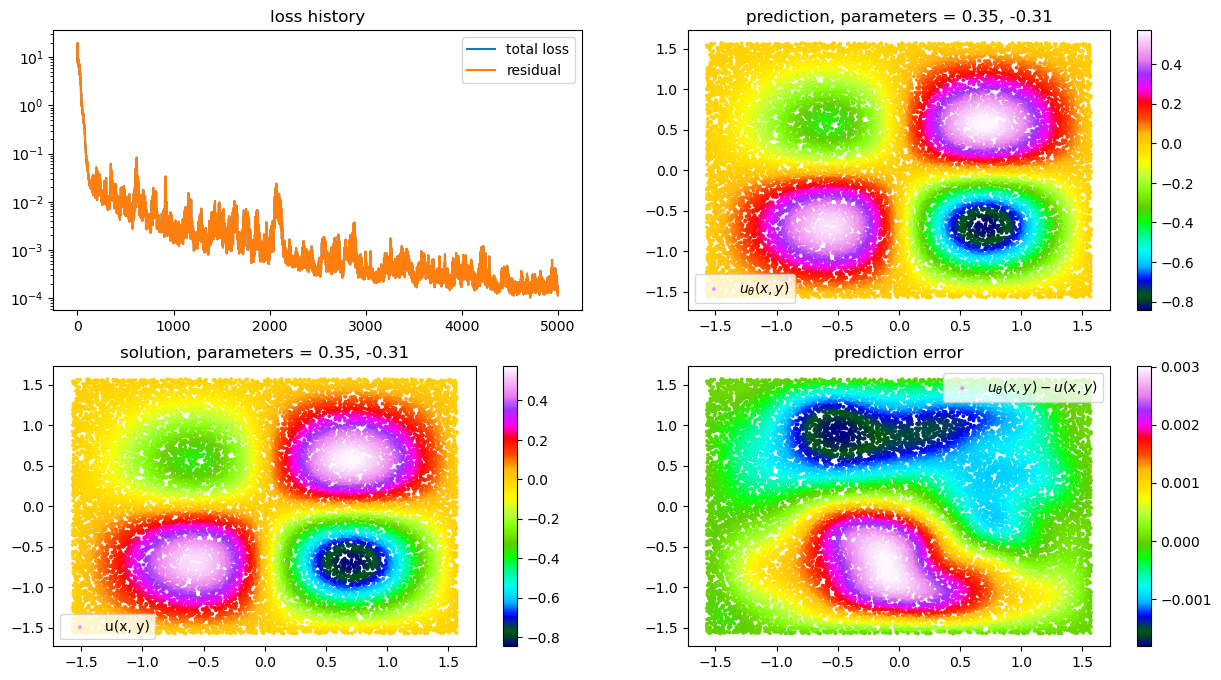

In [6]:
pde = Poisson_2D()
trainer,u_theta = Run_laplacian2D(pde)

In [7]:
def get_param(i):
    params = trainer.pde.parameter_domain.cpu().numpy()
    # pick 1 random parameter
    np.random.seed(0)
    for j in range(i):
        param = [np.random.uniform(params[0][0], params[0][1]), np.random.uniform(params[1][0], params[1][1])]
    param = np.round(param, 2)
    return param

param = get_param(param_num)
print(param)
params = [param]

[0.05 0.22]


In [8]:
def compute_slope(i,tab_nb_vert,tab_err):
    start = [tab_nb_vert[i],tab_err[i]]
    end = [tab_nb_vert[i-1],tab_err[i-1]]
    third = [end[0],start[1]]

    tri_x = [end[0], third[0], start[0], end[0]]
    tri_y = [end[1], third[1], start[1], end[1]
    ]
    plt.plot(tri_x, tri_y, "k--", linewidth=0.5)

    slope = -(np.log(start[1])-np.log(end[1]))/(np.log(start[0])-np.log(end[0]))
    slope = slope.round(2)
    
    vert_mid = [(end[0]+third[0])/2., (end[1]+third[1])/2.]
    
    return slope,vert_mid

## Convergence FEM

In [9]:
def read_csv(testcase,param_num,degree):
    df_FEM = pd.read_csv(result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_FEM = list(df_FEM['nb_vert'].values)
    tab_h_FEM = list(df_FEM['h'].values)
    tab_err_FEM = list(df_FEM['err'].values)
    
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

def run_FEM(degree,new_run=False):
    csv_file = result_dir+f'FEM_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = read_csv(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_FEM = [2**i for i in range(4,9)]
        tab_h_FEM = []
        tab_err_FEM = []

        for nb_vert in tab_nb_vert_FEM:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=5)
            tab_h_FEM.append(solver.h)
            _,norme_L2 = solver.fem(0)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_FEM.append(norme_L2)
            
        df_FEM = pd.DataFrame({'nb_vert': tab_nb_vert_FEM, 'h': tab_h_FEM, 'err': tab_err_FEM})
        df_FEM.to_csv(csv_file, index=False)
            
    return df_FEM,tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM

In [10]:
degree = 3
df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(degree)

Read csv file ../../../results/fenicsx/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree3.csv


degree=1
Read csv file ../../../results/fenicsx/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenicsx/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenicsx/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree3.csv


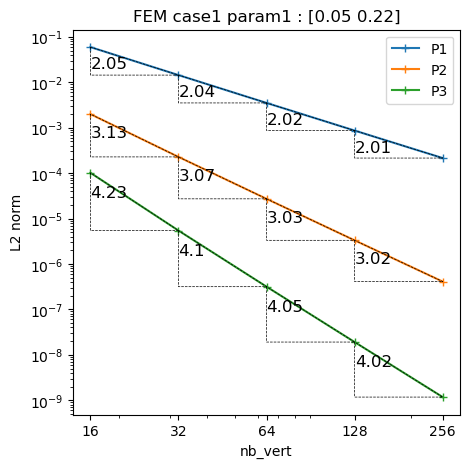

In [11]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='P'+str(d))
    
    for i in range(1,len(tab_nb_vert_FEM)):
        slope, vert_mid = compute_slope(i,tab_nb_vert_FEM,tab_err_FEM)
        plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')
    
plt.xticks(df_FEM['nb_vert'], df_FEM['nb_vert'].round(3).astype(str))
plt.xlabel('nb_vert')
plt.ylabel('L2 norm')
plt.title(f'FEM case{testcase} param{param_num} : {param}')
plt.legend()
plt.savefig(result_dir+f'FEM_case{testcase}_param{param_num}.png')

In [12]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_FEM, _, tab_err_FEM = run_FEM(d)
    if d == 1:
        dict['N'] = tab_nb_vert_FEM
    dict[f'P{d}'] = tab_err_FEM
    
df_deg = pd.DataFrame(dict)

csv_file = result_dir+f'FEM_case{testcase}_param{param_num}.csv'
df_deg.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/fenicsx/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenicsx/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenicsx/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree3.csv


## Convergence PINNs+Corr

In [13]:
def get_test_sample_fromV(i,V_test,trainer):
    # get coordinates of the dof
    XXYY = V_test.tabulate_dof_coordinates()[:,:2]
    print(XXYY.shape)
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return X_test,mu_test


In [16]:
degree_PINNs = 10

def read_csv_Corr(testcase,param_num,degree):
    df_Corr = pd.read_csv(result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv')
    tab_nb_vert_Corr = list(df_Corr['nb_vert'].values)
    tab_h_Corr = list(df_Corr['h'].values)
    tab_err_Corr = list(df_Corr['err'].values)
    
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

def run_Corr(degree,new_run=False):
    csv_file = result_dir+f'Corr_case{testcase}_param{param_num}_degree{degree}.csv'
    if not new_run and os.path.exists(csv_file):
        df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = read_csv_Corr(testcase,param_num,degree)
        print(f"Read csv file {csv_file}")
    else:
        tab_nb_vert_Corr = [2**i for i in range(4,9)]
        tab_h_Corr = []
        tab_err_Corr = []

        for nb_vert in tab_nb_vert_Corr:
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree, high_degree=degree_PINNs)
            tab_h_Corr.append(solver.h)
            
            V_test = solver.V_ex
            X_test,mu_test = get_test_sample_fromV(0,V_test,trainer)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs = dfx.fem.Function(V_test)
            u_PINNs.x.array[:] = phi_tild.copy()
            
            V_test = solver.V
            X_test,mu_test = get_test_sample_fromV(0,V_test,trainer)
            pred = u_theta.setup_w_dict(X_test, mu_test)
            phi_tild_inter = pred["w"][:,0].cpu().detach().numpy()
            
            u_PINNs_inter = dfx.fem.Function(V_test)
            u_PINNs_inter.x.array[:] = phi_tild_inter.copy()
            
            _,_,norme_L2 = solver.corr_add(0,u_PINNs,u_PINNs_inter)
            print(f"nb_vert={nb_vert}, norme_L2={norme_L2}")
            tab_err_Corr.append(norme_L2)
            
        df_Corr = pd.DataFrame({'nb_vert': tab_nb_vert_Corr, 'h': tab_h_Corr, 'err': tab_err_Corr})
        df_Corr.to_csv(csv_file, index=False)
            
    return df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr

In [17]:
d = 1
df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)

hmax =  0.29619219587722484
(22801, 2)
(256, 2)
nb_vert=16, norme_L2=0.00022840496192338158
hmax =  0.1433188044567218
(96721, 2)
(1024, 2)
nb_vert=32, norme_L2=5.6676327355183126e-05
hmax =  0.07052195139933942
(398161, 2)


OutOfMemoryError: CUDA out of memory. Tried to allocate 184.00 MiB. GPU 

degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/Corr_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/Corr_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/Corr_case1_param1_degree3.csv


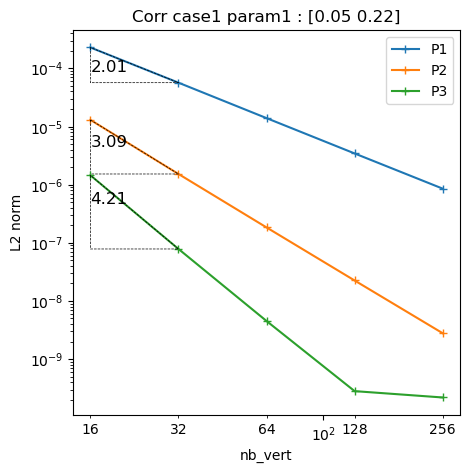

In [44]:
plt.figure(figsize=(5, 5))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr, tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], "+-", label='P'+str(d))
    
    slope, vert_mid = compute_slope(1,tab_nb_vert_Corr,tab_err_Corr)
    plt.text(vert_mid[0]+1e-2 , vert_mid[1], str(slope), fontsize=12, ha='left', va='top')

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=True)
plt.xlabel("nb_vert")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'Corr_case{testcase}_param{param_num}.png')

In [45]:
dict = {}
for d in [1, 2, 3]:
    print(f"degree={d}")
    _, tab_nb_vert_Corr, _, tab_err_Corr = run_Corr(d)
    if d == 1:
        dict['N'] = tab_nb_vert_Corr
    dict[f'P{d}'] = tab_err_Corr
    
df_deg_Corr = pd.DataFrame(dict)

csv_file = result_dir+f'Corr_case{testcase}_param{param_num}.csv'
df_deg_Corr.to_csv(csv_file, index=False)

degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/Corr_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/Corr_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/Corr_case1_param1_degree3.csv


## Plots

degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/FEM_case1_param1_degree3.csv
degree=1
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/Corr_case1_param1_degree1.csv
degree=2
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/Corr_case1_param1_degree2.csv
degree=3
Read csv file ../../../results/fenics/test_2D/testcase1/version1/cvg/Corr_case1_param1_degree3.csv


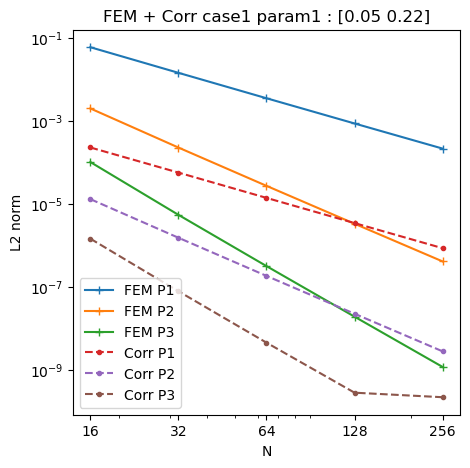

In [46]:
plt.figure(figsize=(5, 5))

# plot FEM error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_FEM, tab_nb_vert_FEM, tab_h_FEM, tab_err_FEM = run_FEM(d)
    plt.loglog(df_FEM['nb_vert'], df_FEM['err'], "+-", label='FEM P'+str(d))

# plot Corr error (L2 norm) as a function of h
for d in [1, 2, 3]:
    print(f"degree={d}")
    df_Corr,tab_nb_vert_Corr, tab_h_Corr, tab_err_Corr = run_Corr(d)
    plt.loglog(df_Corr['nb_vert'], df_Corr['err'], ".--", label='Corr P'+str(d))

plt.xticks(df_Corr['nb_vert'], df_Corr['nb_vert'].round(3).astype(str), minor=False)
plt.xlabel("N")
plt.ylabel('L2 norm')
plt.legend()
plt.title(f'FEM + Corr case{testcase} param{param_num} : {param}')
plt.savefig(result_dir+f'FEM-Corr_case{testcase}_param{param_num}.png')